## Baseline: análisis de estrategias para InceptionV3

In [27]:
import sys
import os
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import albumentations as A
import pickle
import cv2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger, EarlyStopping

project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
if project_root not in sys.path:
    sys.path.append(project_root)
    print(f"Añadido '{project_root}' a sys.path")

from src.architectures import build_model

PROCESSED_DATA_PATH = '../data/processed/'
IMAGE_ROOT_DIR = '../data/raw/color'
OUTPUTS_PATH = '../outputs/'
TARGET_SIZE = (224, 224)
BATCH_SIZE = 32
NUM_CLASSES = 38
EPOCHS = 15
MODEL_NAME = 'InceptionV3' 

balanced_train_df = pd.read_csv(os.path.join(PROCESSED_DATA_PATH, 'df_train_balanced.csv'))
df_splitted = pd.read_csv(os.path.join(PROCESSED_DATA_PATH, 'dataframe_splitted.csv'))
train_df = df_splitted[df_splitted['split'] == 'train']
val_df = df_splitted[df_splitted['split'] == 'valid']


#### DEFINICIÓN DE AUMENTACIONES Y GENERADORES

In [28]:
# Estrategia "Sin Color" (Geométrica)
transform_geometric_only = A.Compose([
    A.ShiftScaleRotate(shift_limit=0.25, scale_limit=0.2, rotate_limit=25, border_mode=cv2.BORDER_REPLICATE, p=0.75),
    A.Affine(shear={'x': (-12, 12), 'y': (-12, 12)}, p=0.5),
    A.HorizontalFlip(p=0.5),
    A.Resize(224, 224, always_apply=True)])

# Estrategia "Con Color" (Geométrica + Color)
transform_geometric_and_color = A.Compose([
    A.Rotate(limit=180, p=0.5),
    A.HorizontalFlip(p=0.5), A.VerticalFlip(p=0.5),
    A.RandomScale(scale_limit=0.1, p=0.3),
    A.RandomCrop(width=200, height=200, p=0.3),
    A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.3),
    A.HueSaturationValue(hue_shift_limit=20, sat_shift_limit=30, val_shift_limit=20, p=0.3),
    A.GaussianBlur(blur_limit=(3, 5), p=0.2),
    A.Resize(224, 224, always_apply=True),])

def apply_albumentations(image, transform):
    image = (image * 255).astype(np.uint8)
    return transform(image=image)['image'].astype(np.float32) / 255.0

datagen_geometric = ImageDataGenerator(preprocessing_function=lambda x: apply_albumentations(x, transform_geometric_only))
datagen_color = ImageDataGenerator(preprocessing_function=lambda x: apply_albumentations(x, transform_geometric_and_color))
datagen_val = ImageDataGenerator(rescale=1./255)

flow_kwargs = {'directory': IMAGE_ROOT_DIR, 'x_col': 'relative_path', 'y_col': 'class', 'target_size': TARGET_SIZE, 'batch_size': BATCH_SIZE, 'class_mode': 'categorical'}

train_gen_unbalanced_geometric = datagen_geometric.flow_from_dataframe(dataframe=train_df, shuffle=True, **flow_kwargs)
train_gen_unbalanced_color = datagen_color.flow_from_dataframe(dataframe=train_df, shuffle=True, **flow_kwargs)
train_gen_balanced_geometric = datagen_geometric.flow_from_dataframe(dataframe=balanced_train_df, shuffle=True, **flow_kwargs)
train_gen_balanced_color = datagen_color.flow_from_dataframe(dataframe=balanced_train_df, shuffle=True, **flow_kwargs)
val_generator = datagen_val.flow_from_dataframe(dataframe=val_df, shuffle=False, **flow_kwargs)


Found 38013 validated image filenames belonging to 38 classes.
Found 38013 validated image filenames belonging to 38 classes.
Found 146452 validated image filenames belonging to 38 classes.
Found 146452 validated image filenames belonging to 38 classes.
Found 5431 validated image filenames belonging to 38 classes.


### Experimentos

In [29]:
experiments = [
    {'name': 'Unbalanced_Geometric', 'generator': train_gen_unbalanced_geometric},
    {'name': 'Unbalanced_Color',     'generator': train_gen_unbalanced_color},
    {'name': 'Balanced_Geometric',   'generator': train_gen_balanced_geometric},
    {'name': 'Balanced_Color',       'generator': train_gen_balanced_color},
]

histories = {} 

for exp in experiments:
    exp_name = f"exp_{MODEL_NAME}_{exp['name']}"
    print(f"\n{'='*25}\nIniciando Experimento: {exp_name}\n{'='*25}")

    exp_output_dir = os.path.join(OUTPUTS_PATH, exp_name)
    os.makedirs(exp_output_dir, exist_ok=True)

    model = build_model(model_name=MODEL_NAME, num_classes=NUM_CLASSES, fine_tune=False)
    
    # --- LISTA DE CALLBACKS ACTUALIZADA ---
    callbacks = [
        ModelCheckpoint(
            os.path.join(exp_output_dir, 'best_model.keras'), 
            monitor='val_accuracy', 
            save_best_only=True, 
            mode='max',
            verbose=1),

        EarlyStopping(
            monitor='val_accuracy',     
            patience=4,            
            verbose=1,
            mode='max',
            restore_best_weights=True ),
        CSVLogger(os.path.join(exp_output_dir, 'training_log.csv'))]
    
    history = model.fit(
        exp['generator'],
        epochs=EPOCHS,
        validation_data=val_generator,
        callbacks=callbacks)
    histories[exp['name']] = pd.DataFrame(history.history)

print("\nTODOS LOS EXPERIMENTOS HAN FINALIZADO.")



Iniciando Experimento: exp_InceptionV3_Unbalanced_Geometric
Modelo InceptionV3 construido. Capas base entrenables: False
Epoch 1/15


/home/adrian/miniconda3/envs/tf_minimal_env/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1188/1188 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.5929 - loss: 1.4964
Epoch 1: val_accuracy improved from -inf to 0.52366, saving model to ../outputs/exp_InceptionV3_Unbalanced_Geometric/best_model.keras
1188/1188 ━━━━━━━━━━━━━━━━━━━━ 76s 55ms/step - accuracy: 0.5929 - loss: 1.4961 - val_accuracy: 0.5237 - val_loss: 1.8095
Epoch 2/15
1187/1188 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.7690 - loss: 0.7463
Epoch 2: val_accuracy improved from 0.52366 to 0.53029, saving model to ../outputs/exp_InceptionV3_Unbalanced_Geometric/best_model.keras
1188/1188 ━━━━━━━━━━━━━━━━━━━━ 56s 47ms/step - accuracy: 0.7690 - loss: 0.7463 - val_accuracy: 0.5303 - val_loss: 1.7565
Epoch 3/15
1188/1188 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.7851 - loss: 0.6755
Epoch 3: val_accuracy improved from 0.53029 to 0.55828, saving model to ../outputs/exp_InceptionV3_Unbalanced_Geometric/best_model.keras
1188/1188 ━━━━━━━━━━━━━━━━━━━━ 58s 49ms/step - accuracy: 0.7851 - loss: 0.6755 - val_accuracy:


Generando matriz de gráficos comparativos con eje de Loss unificado...
Límite del eje Y para todos los gráficos de Loss será: 2.35


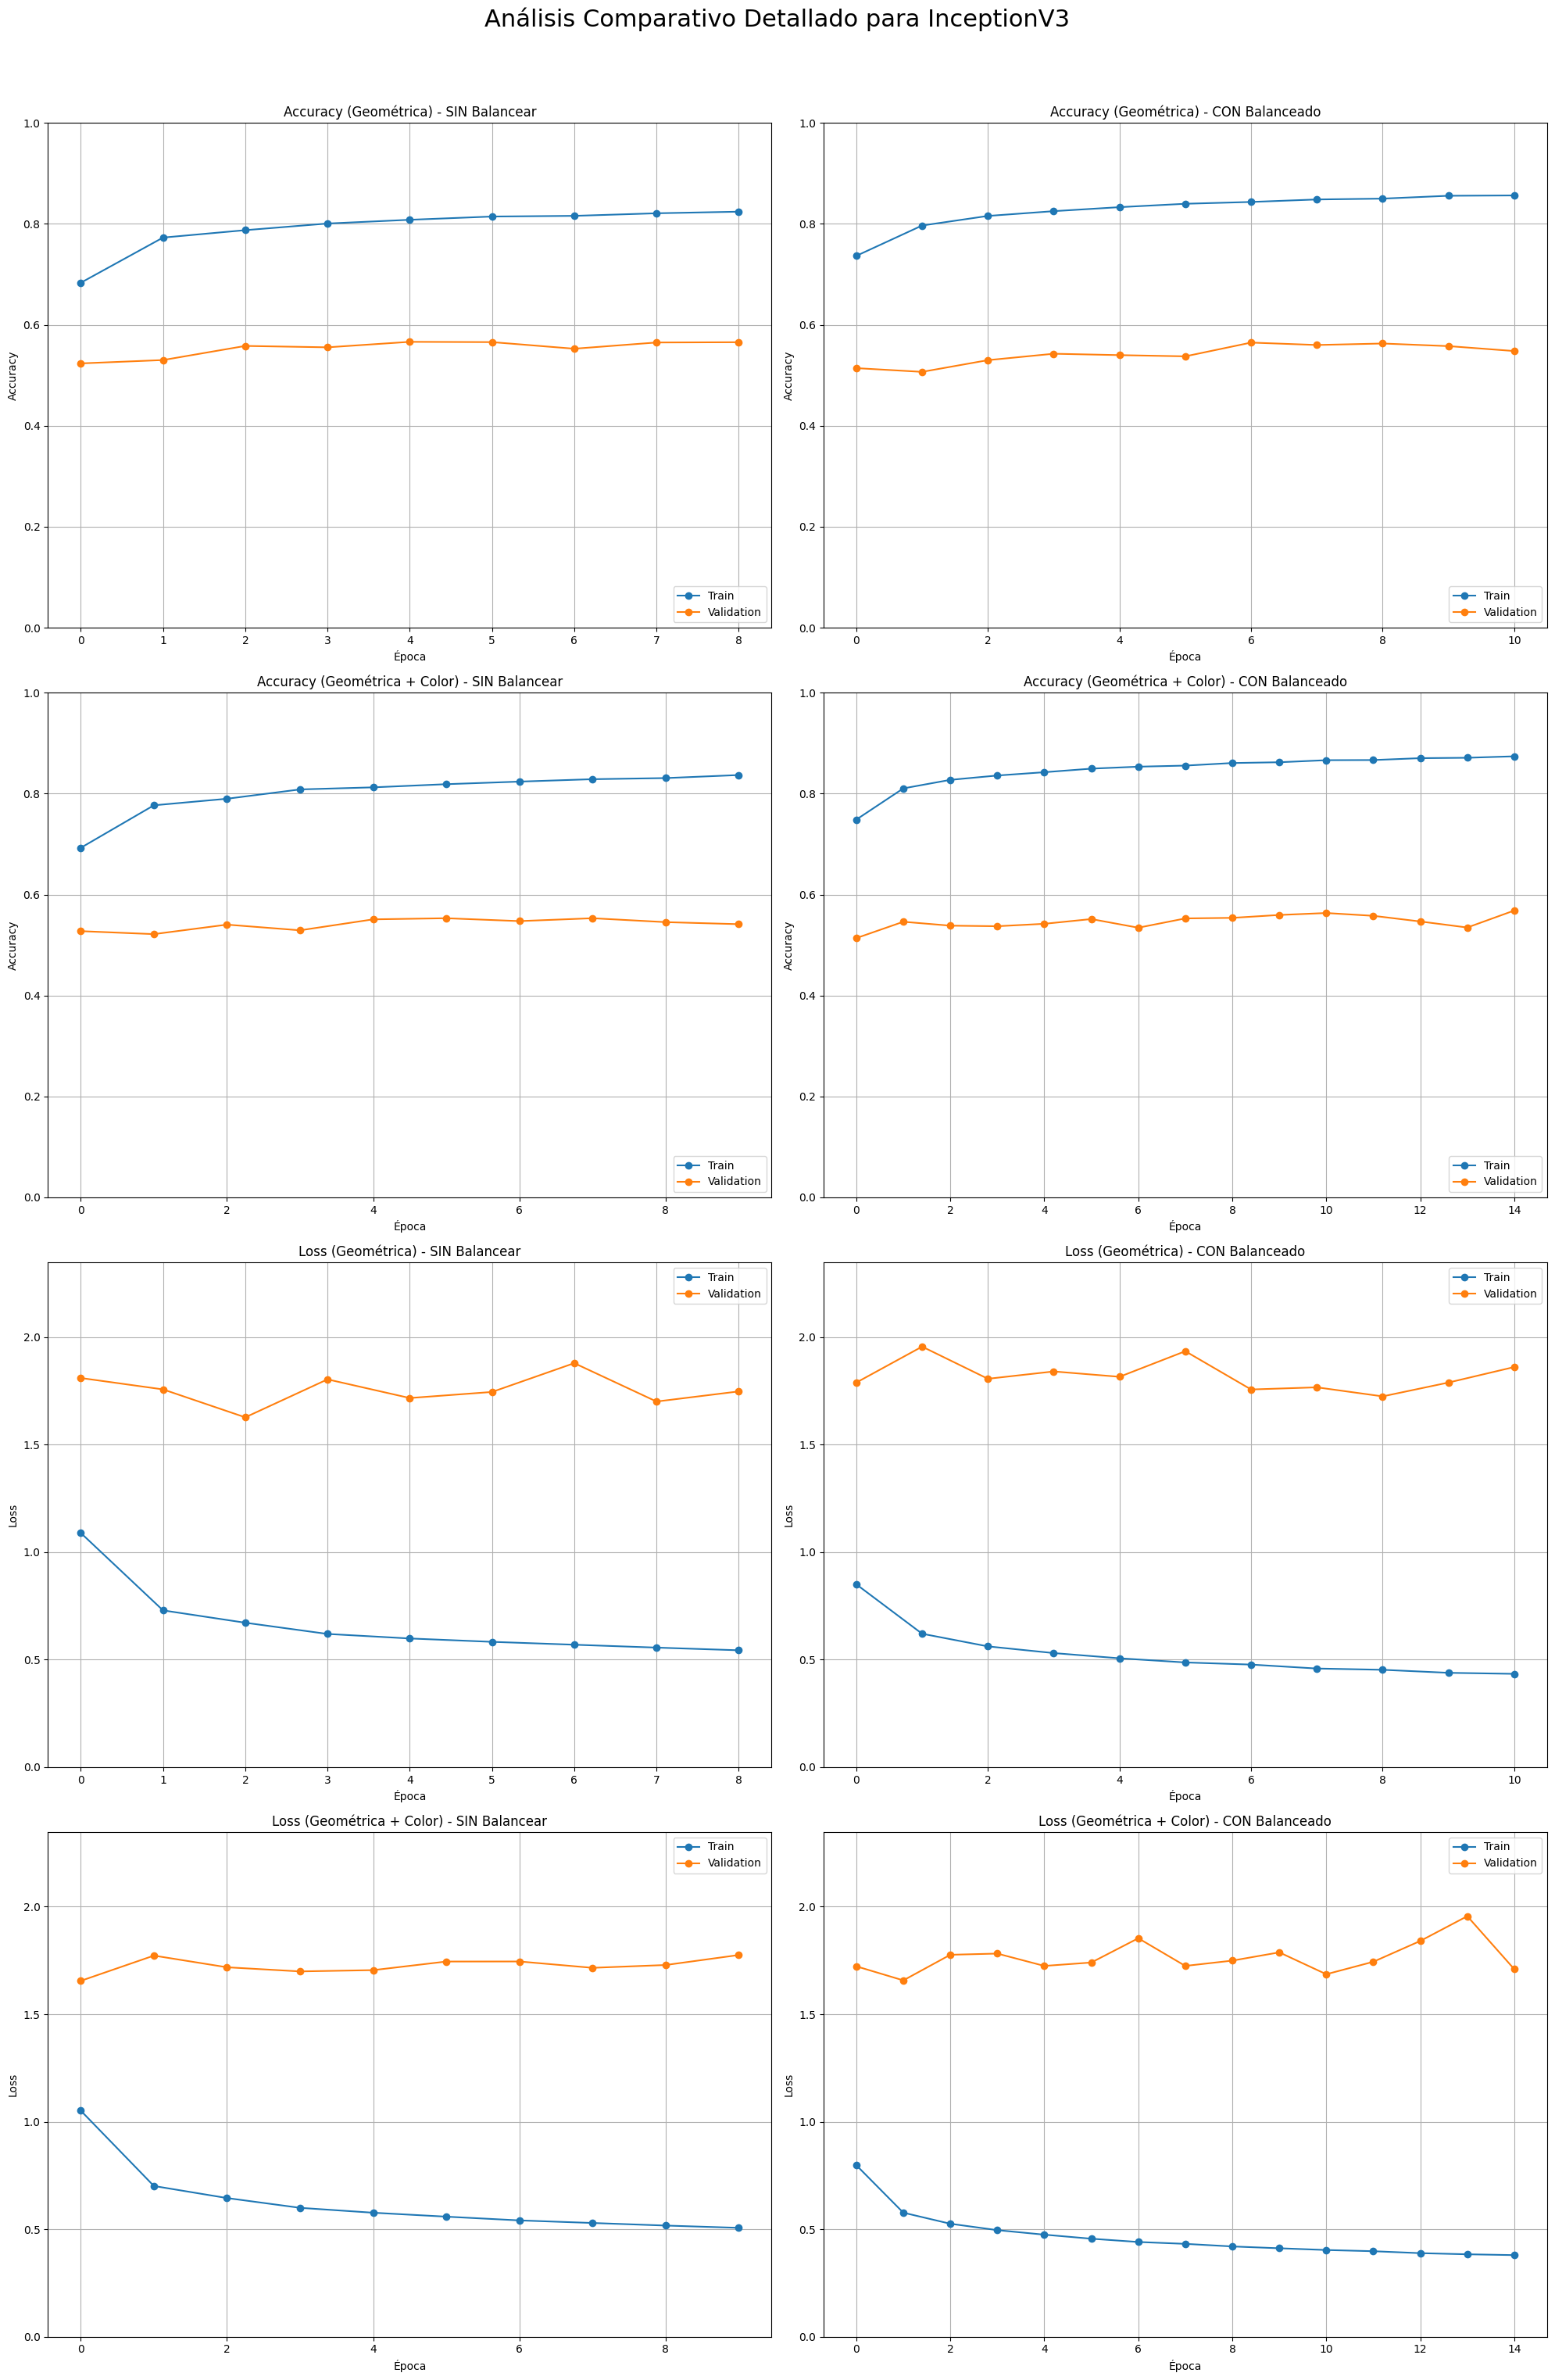

In [30]:
# --- 5. COMPARACIÓN VISUAL FINAL (con eje Y de Loss unificado) ---

print("\nGenerando matriz de gráficos comparativos con eje de Loss unificado...")

# --- Paso previo: Calcular el MÁXIMO LOSS global entre todos los experimentos ---
overall_max_loss = 0
for name, history_df in histories.items():
    if history_df is not None:
        # Encontrar el máximo de esta instancia (entre train y validation)
        max_train_loss = history_df['loss'].max()
        max_val_loss = history_df['val_loss'].max()
        current_max = max(max_train_loss, max_val_loss)
        # Actualizar el máximo global si el actual es mayor
        if current_max > overall_max_loss:
            overall_max_loss = current_max

# Definimos el límite superior del eje Y para todos los gráficos de loss (con un 20% de margen)
loss_y_limit = overall_max_loss * 1.2
print(f"Límite del eje Y para todos los gráficos de Loss será: {loss_y_limit:.2f}")


# --- Creación de la figura y los ejes ---
fig, axes = plt.subplots(4, 2, figsize=(20, 32))
fig.suptitle(f'Análisis Comparativo Detallado para {MODEL_NAME}', fontsize=22)


# --- Función auxiliar para dibujar las curvas (ACTUALIZADA) ---
def plot_curves(ax, history_df, metric_name, title, y_limit=None):
    """Dibuja las curvas y ajusta los ejes Y según la métrica y un límite opcional."""
    if history_df is None:
        # ... (código para gráfico vacío) ...
        return

    ax.plot(history_df[metric_name], 'o-', label='Train')
    ax.plot(history_df[f'val_{metric_name}'], 'o-', label='Validation')
    ax.set_title(title); ax.set_xlabel('Época'); ax.set_ylabel(metric_name.capitalize()); ax.grid(True)
    
    # --- Lógica de Ejes y Leyenda ---
    if 'accuracy' in metric_name:
        ax.legend(loc='lower right')
        ax.set_ylim([0, 1])
    else: # 'loss'
        ax.legend(loc='upper right')
        if y_limit is not None:
            ax.set_ylim([0, y_limit]) # Aplicamos el límite global calculado


# --- Obtenemos los historiales ---
h_unb_geo = histories.get('Unbalanced_Geometric')
h_unb_col = histories.get('Unbalanced_Color')
h_bal_geo = histories.get('Balanced_Geometric')
h_bal_col = histories.get('Balanced_Color')


# --- Dibujado de las 4 filas de gráficos ---
# Fila 1: Accuracy SIN Color
plot_curves(axes[0, 0], h_unb_geo, 'accuracy', 'Accuracy (Geométrica) - SIN Balancear')
plot_curves(axes[0, 1], h_bal_geo, 'accuracy', 'Accuracy (Geométrica) - CON Balanceado')
# Fila 2: Accuracy CON Color
plot_curves(axes[1, 0], h_unb_col, 'accuracy', 'Accuracy (Geométrica + Color) - SIN Balancear')
plot_curves(axes[1, 1], h_bal_col, 'accuracy', 'Accuracy (Geométrica + Color) - CON Balanceado')

# Fila 3: Loss SIN Color (pasando el límite del eje Y)
plot_curves(axes[2, 0], h_unb_geo, 'loss', 'Loss (Geométrica) - SIN Balancear', y_limit=loss_y_limit)
plot_curves(axes[2, 1], h_bal_geo, 'loss', 'Loss (Geométrica) - CON Balanceado', y_limit=loss_y_limit)
# Fila 4: Loss CON Color (pasando el límite del eje Y)
plot_curves(axes[3, 0], h_unb_col, 'loss', 'Loss (Geométrica + Color) - SIN Balancear', y_limit=loss_y_limit)
plot_curves(axes[3, 1], h_bal_col, 'loss', 'Loss (Geométrica + Color) - CON Balanceado', y_limit=loss_y_limit)


# Ajustar y mostrar
plt.tight_layout(rect=[0, 0.03, 1, 0.96])
plt.savefig(os.path.join(OUTPUTS_PATH, 'final_comparison_unified_loss_axis.png'))
plt.show()

In [6]:
import sys
import os
project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))

if project_root not in sys.path:
    sys.path.append(project_root)
    print(f"Añadido '{project_root}' a sys.path")

import cv2
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import albumentations as A
import pickle
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, CSVLogger

# Importar nuestra función constructora de modelos desde el módulo src
from src.architectures import build_model

# Configuración de Rutas y Constantes
PROCESSED_DATA_PATH = '../data/processed/'
IMAGE_ROOT_DIR = '../data/raw/color'
OUTPUTS_PATH = '../outputs/'
TARGET_SIZE = (224, 224)
BATCH_SIZE = 32
NUM_CLASSES = 38
EPOCHS = 2

In [7]:
# --- Carga y Preparación de Datos ---
print("Cargando dataframes pre-procesados...")

# Cargamos el DataFrame de entrenamiento YA BALANCEADO desde el notebook 2
train_path = os.path.join(PROCESSED_DATA_PATH, 'df_train_balanced.csv')
balanced_train_df = pd.read_csv(train_path)

# Cargamos el DataFrame completo para obtener el conjunto de validación
df_splitted = pd.read_csv(os.path.join(PROCESSED_DATA_PATH, 'dataframe_splitted.csv'))
val_df = df_splitted[df_splitted['split'] == 'valid']

print(f"DataFrame de entrenamiento balanceado cargado con {len(balanced_train_df)} muestras.")
print(f"DataFrame de validación listo con {len(val_df)} muestras.")

Cargando dataframes pre-procesados...
DataFrame de entrenamiento balanceado cargado con 146452 muestras.
DataFrame de validación listo con 5431 muestras.


In [8]:
# --- Celda de Definición de Aumentación y Generadores (CORREGIDA) ---

# Estrategia 1: Conservadora
transform_conservative = A.Compose([
    A.Rotate(limit=180, p=0.5),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.RandomScale(scale_limit=0.1, p=0.3),
    A.RandomCrop(width=200, height=200, p=0.3),
    A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.3),
    A.HueSaturationValue(hue_shift_limit=20, sat_shift_limit=30, val_shift_limit=20, p=0.3),
    A.GaussianBlur(blur_limit=(3, 5), p=0.2),
    A.Resize(224, 224, always_apply=True),
])

# Estrategia 2: Intensiva 
mult = 2
scaler = 1.5
# LA LLAMAREMOS 'transform_intensive' PARA QUE COINCIDA
transform_intensive = A.Compose([
    A.Rotate(limit=180, p=1.0),
    A.HorizontalFlip(p=1.0),
    A.VerticalFlip(p=1.0),
    A.RandomCrop(width=180, height=180, p=0.6),
    A.RandomBrightnessContrast(brightness_limit=0.1 * scaler, contrast_limit=0.1 * scaler, p=0.4),
    A.HueSaturationValue(hue_shift_limit=15 * scaler, sat_shift_limit=30 * scaler, val_shift_limit=15 * scaler, p=0.4),
    A.GaussNoise(p=0.2),
    A.GaussianBlur(blur_limit=(7, 9), p=0.5),
    A.RandomScale(scale_limit=0.1, p=1.0), 
    A.CLAHE(clip_limit=2.0, p=0.8),
    A.Resize(224, 224, always_apply=True),
])

# --- Creación de los Generadores ---

# Función wrapper
def apply_albumentations(image, transform):
    image = (image * 255).astype(np.uint8)
    return transform(image=image)['image'].astype(np.float32) / 255.0

# Generador CONSERVADOR
datagen_conservative = ImageDataGenerator(preprocessing_function=lambda x: apply_albumentations(x, transform_conservative))
train_generator_conservative = datagen_conservative.flow_from_dataframe(
    dataframe=balanced_train_df, directory=IMAGE_ROOT_DIR, x_col='relative_path', y_col='class',
    target_size=TARGET_SIZE, batch_size=BATCH_SIZE, class_mode='categorical', shuffle=True
)

# Generador INTENSIVO (usando el nombre correcto 'transform_intensive')
datagen_intensive = ImageDataGenerator(preprocessing_function=lambda x: apply_albumentations(x, transform_intensive))
train_generator_intensive = datagen_intensive.flow_from_dataframe(
    dataframe=balanced_train_df, directory=IMAGE_ROOT_DIR, x_col='relative_path', y_col='class',
    target_size=TARGET_SIZE, batch_size=BATCH_SIZE, class_mode='categorical', shuffle=True
)

# Generador de VALIDACIÓN
datagen_val = ImageDataGenerator(rescale=1./255)
val_generator = datagen_val.flow_from_dataframe(
    dataframe=val_df, directory=IMAGE_ROOT_DIR, x_col='relative_path', y_col='class',
    target_size=TARGET_SIZE, batch_size=BATCH_SIZE, class_mode='categorical', shuffle=False
)

print("Generadores listos con nombres de variables consistentes.")

Found 146452 validated image filenames belonging to 38 classes.
Found 146452 validated image filenames belonging to 38 classes.
Found 5431 validated image filenames belonging to 38 classes.
Generadores listos con nombres de variables consistentes.


In [9]:
# --- Celda 3: Definición de Aumentación y Generadores (con Estrategia 'Base') ---

# Estrategia 1: Conservadora (se mantiene igual)
transform_conservative = A.Compose([
    A.Rotate(limit=180, p=0.5),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.RandomScale(scale_limit=0.1, p=0.3),
    A.RandomCrop(width=200, height=200, p=0.3),
    A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.3),
    A.HueSaturationValue(hue_shift_limit=20, sat_shift_limit=30, val_shift_limit=20, p=0.3),
    A.GaussianBlur(blur_limit=(3, 5), p=0.2),
    A.Resize(224, 224, always_apply=True),
])

# Estrategia 2: 'Base' (Reemplaza a la 'Intensiva')
# Esta pipeline traduce la configuración de Keras que solicitaste a Albumentations.
transform_base = A.Compose([
    # Combina rotación, desplazamiento y zoom en una sola transformación eficiente
    A.ShiftScaleRotate(
        shift_limit=0.25,      # Equivalente a width/height_shift_range
        scale_limit=0.2,       # Equivalente a zoom_range
        rotate_limit=25,       # Equivalente a rotation_range
        border_mode=cv2.BORDER_REPLICATE, # Equivalente a fill_mode='nearest'
        p=0.75 # Probabilidad de aplicar alguna de estas transformaciones
    ),
    # Aplica la transformación de 'shear' (cizallamiento)
    A.Affine(
        shear={'x': (-15, 15), 'y': (-15, 15)}, # shear_range de 0.2 es aprox. 11-12 grados
        p=0.5
    ),
    # Volteo horizontal
    A.HorizontalFlip(p=0.5),
    
    # MUY IMPORTANTE: Asegura que el tamaño final siempre sea 224x224
    A.Resize(224, 224, always_apply=True)
])

# --- El resto del código de la celda ---

# Función wrapper
def apply_albumentations(image, transform):
    image = (image * 255).astype(np.uint8)
    return transform(image=image)['image'].astype(np.float32) / 255.0

# Generador CONSERVADOR
datagen_conservative = ImageDataGenerator(preprocessing_function=lambda x: apply_albumentations(x, transform_conservative))
train_generator_conservative = datagen_conservative.flow_from_dataframe(
    dataframe=balanced_train_df, directory=IMAGE_ROOT_DIR, x_col='relative_path', y_col='class',
    target_size=TARGET_SIZE, batch_size=BATCH_SIZE, class_mode='categorical', shuffle=True
)

# Generador BASE (ahora usando la nueva pipeline)
datagen_base = ImageDataGenerator(preprocessing_function=lambda x: apply_albumentations(x, transform_base))
train_generator_base = datagen_base.flow_from_dataframe(
    dataframe=balanced_train_df, directory=IMAGE_ROOT_DIR, x_col='relative_path', y_col='class',
    target_size=TARGET_SIZE, batch_size=BATCH_SIZE, class_mode='categorical', shuffle=True
)

# Generador de VALIDACIÓN
datagen_val = ImageDataGenerator(rescale=1./255)
val_generator = datagen_val.flow_from_dataframe(
    dataframe=val_df, directory=IMAGE_ROOT_DIR, x_col='relative_path', y_col='class',
    target_size=TARGET_SIZE, batch_size=BATCH_SIZE, class_mode='categorical', shuffle=False
)

print("Generadores listos con las estrategias 'conservative' y 'base'.")


Found 146452 validated image filenames belonging to 38 classes.
Found 146452 validated image filenames belonging to 38 classes.
Found 5431 validated image filenames belonging to 38 classes.
Generadores listos con las estrategias 'conservative' y 'base'.



Iniciando Experimento: exp_baseline_InceptionV3_conservative


I0000 00:00:1749600460.356834   46466 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13687 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3080 Ti Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6


Modelo InceptionV3 construido con BATCH NORMALIZATION. Capas base congeladas.
Epoch 1/2


/home/adrian/miniconda3/envs/tf_minimal_env/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1749600468.355530   46776 service.cc:152] XLA service 0x7f1f00002ba0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1749600468.355698   46776 service.cc:160]   StreamExecutor device (0): NVIDIA GeForce RTX 3080 Ti Laptop GPU, Compute Capability 8.6
2025-06-10 21:07:48.500157: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1749600470.120455   46776 cuda_dnn.cc:529] Loaded cuDNN version 90300
2025-06-10 21:

   2/4577 ━━━━━━━━━━━━━━━━━━━━ 5:52 77ms/step - accuracy: 0.0078 - loss: 4.4876       

I0000 00:00:1749600479.673081   46776 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1730/4577 ━━━━━━━━━━━━━━━━━━━━ 1:54 40ms/step - accuracy: 0.5943 - loss: 1.4258

2025-06-10 21:09:11.265717: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_8427', 4 bytes spill stores, 4 bytes spill loads

2025-06-10 21:09:11.338841: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_8427', 220 bytes spill stores, 220 bytes spill loads

2025-06-10 21:09:11.808126: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_8427', 8 bytes spill stores, 8 bytes spill loads

2025-06-10 21:09:11.821583: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_9099', 64 bytes spill stores, 64 bytes spill loads

2025-06-10 21:09:11.856726: I external/loc

4577/4577 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.6761 - loss: 1.0919

2025-06-10 21:11:14.091425: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_2476', 88 bytes spill stores, 88 bytes spill loads

2025-06-10 21:11:21.459503: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_2467', 4 bytes spill stores, 4 bytes spill loads

2025-06-10 21:11:21.805802: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_2467', 8 bytes spill stores, 8 bytes spill loads

2025-06-10 21:11:21.819869: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_2467', 220 bytes spill stores, 220 bytes spill loads

2025-06-10 21:11:21.936909: I external/loc


Epoch 1: val_accuracy improved from -inf to 0.54907, saving model to ../outputs/exp_baseline_InceptionV3_conservative/best_model.keras
4577/4577 ━━━━━━━━━━━━━━━━━━━━ 225s 46ms/step - accuracy: 0.6761 - loss: 1.0919 - val_accuracy: 0.5491 - val_loss: 1.6344
Epoch 2/2
4577/4577 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.8031 - loss: 0.6043
Epoch 2: val_accuracy did not improve from 0.54907
4577/4577 ━━━━━━━━━━━━━━━━━━━━ 185s 40ms/step - accuracy: 0.8031 - loss: 0.6043 - val_accuracy: 0.5349 - val_loss: 1.7272
Restoring model weights from the end of the best epoch: 1.


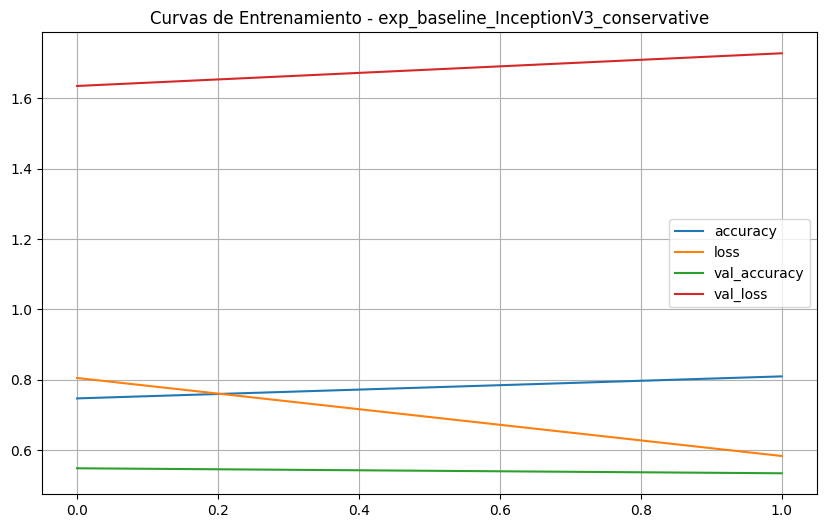


Experimento exp_baseline_InceptionV3_conservative finalizado. Resultados en: ../outputs/exp_baseline_InceptionV3_conservative

Iniciando Experimento: exp_baseline_InceptionV3_base
Modelo InceptionV3 construido con BATCH NORMALIZATION. Capas base congeladas.
Epoch 1/2


/home/adrian/miniconda3/envs/tf_minimal_env/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


4576/4577 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.6595 - loss: 1.1576
Epoch 1: val_accuracy improved from -inf to 0.52256, saving model to ../outputs/exp_baseline_InceptionV3_base/best_model.keras
4577/4577 ━━━━━━━━━━━━━━━━━━━━ 219s 46ms/step - accuracy: 0.6595 - loss: 1.1575 - val_accuracy: 0.5226 - val_loss: 1.7726
Epoch 2/2
4576/4577 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.7911 - loss: 0.6499
Epoch 2: val_accuracy improved from 0.52256 to 0.55220, saving model to ../outputs/exp_baseline_InceptionV3_base/best_model.keras
4577/4577 ━━━━━━━━━━━━━━━━━━━━ 202s 44ms/step - accuracy: 0.7911 - loss: 0.6499 - val_accuracy: 0.5522 - val_loss: 1.6624
Restoring model weights from the end of the best epoch: 2.


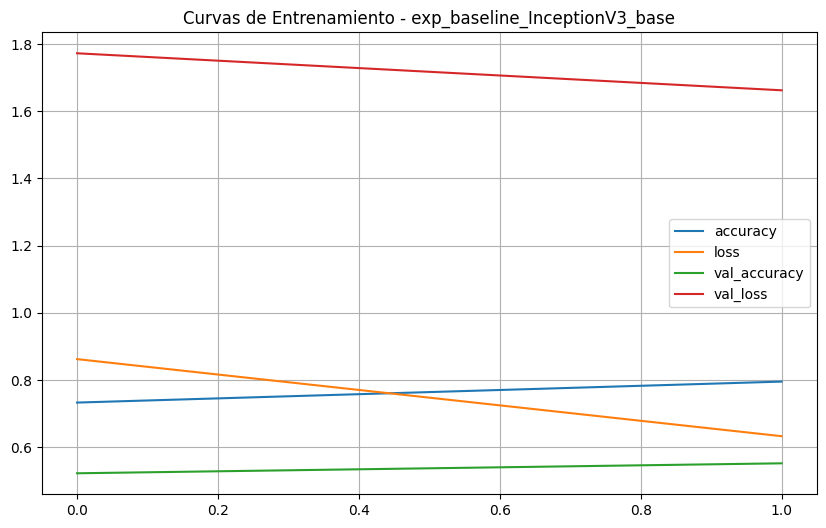


Experimento exp_baseline_InceptionV3_base finalizado. Resultados en: ../outputs/exp_baseline_InceptionV3_base

Iniciando Experimento: exp_baseline_VGG19_conservative
80134624/80134624 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step
Modelo VGG19 construido con BATCH NORMALIZATION. Capas base congeladas.
Epoch 1/2


2025-06-10 21:21:43.878038: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_767', 188 bytes spill stores, 188 bytes spill loads

2025-06-10 21:21:43.929334: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1864', 36 bytes spill stores, 44 bytes spill loads

2025-06-10 21:21:44.126387: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1864', 32 bytes spill stores, 32 bytes spill loads

2025-06-10 21:21:44.152036: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1864', 56 bytes spill stores, 56 bytes spill loads



1730/4577 ━━━━━━━━━━━━━━━━━━━━ 3:32 74ms/step - accuracy: 0.5464 - loss: 1.6008

2025-06-10 21:24:02.129805: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_767', 200 bytes spill stores, 200 bytes spill loads

2025-06-10 21:24:02.290742: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_767', 4 bytes spill stores, 4 bytes spill loads

2025-06-10 21:24:02.387702: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1864', 56 bytes spill stores, 56 bytes spill loads

2025-06-10 21:24:02.448839: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1864', 28 bytes spill stores, 32 bytes spill loads

2025-06-10 21:24:02.499258: I external/loc

4577/4577 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 0.6376 - loss: 1.2280

2025-06-10 21:27:51.538408: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_267', 4 bytes spill stores, 4 bytes spill loads

2025-06-10 21:27:51.788900: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_267', 200 bytes spill stores, 200 bytes spill loads




Epoch 1: val_accuracy improved from -inf to 0.52753, saving model to ../outputs/exp_baseline_VGG19_conservative/best_model.keras
4577/4577 ━━━━━━━━━━━━━━━━━━━━ 376s 80ms/step - accuracy: 0.6376 - loss: 1.2279 - val_accuracy: 0.5275 - val_loss: 1.8916
Epoch 2/2
4577/4577 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 0.7814 - loss: 0.6766
Epoch 2: val_accuracy improved from 0.52753 to 0.55146, saving model to ../outputs/exp_baseline_VGG19_conservative/best_model.keras
4577/4577 ━━━━━━━━━━━━━━━━━━━━ 353s 77ms/step - accuracy: 0.7814 - loss: 0.6765 - val_accuracy: 0.5515 - val_loss: 2.0484
Restoring model weights from the end of the best epoch: 2.


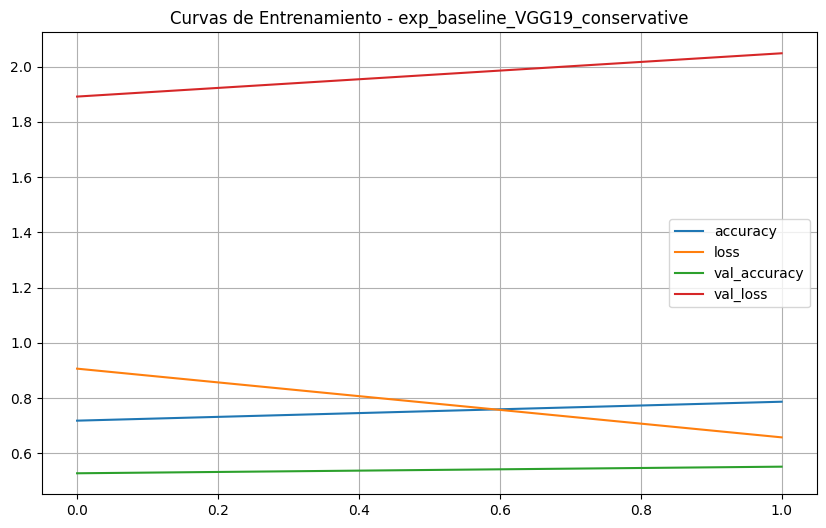


Experimento exp_baseline_VGG19_conservative finalizado. Resultados en: ../outputs/exp_baseline_VGG19_conservative

Iniciando Experimento: exp_baseline_VGG19_base
Modelo VGG19 construido con BATCH NORMALIZATION. Capas base congeladas.
Epoch 1/2
4577/4577 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 0.6386 - loss: 1.2225
Epoch 1: val_accuracy improved from -inf to 0.51593, saving model to ../outputs/exp_baseline_VGG19_base/best_model.keras
4577/4577 ━━━━━━━━━━━━━━━━━━━━ 355s 77ms/step - accuracy: 0.6387 - loss: 1.2225 - val_accuracy: 0.5159 - val_loss: 2.4672
Epoch 2/2
4577/4577 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 0.7903 - loss: 0.6468
Epoch 2: val_accuracy did not improve from 0.51593
4577/4577 ━━━━━━━━━━━━━━━━━━━━ 354s 77ms/step - accuracy: 0.7903 - loss: 0.6468 - val_accuracy: 0.4924 - val_loss: 2.8311
Restoring model weights from the end of the best epoch: 1.


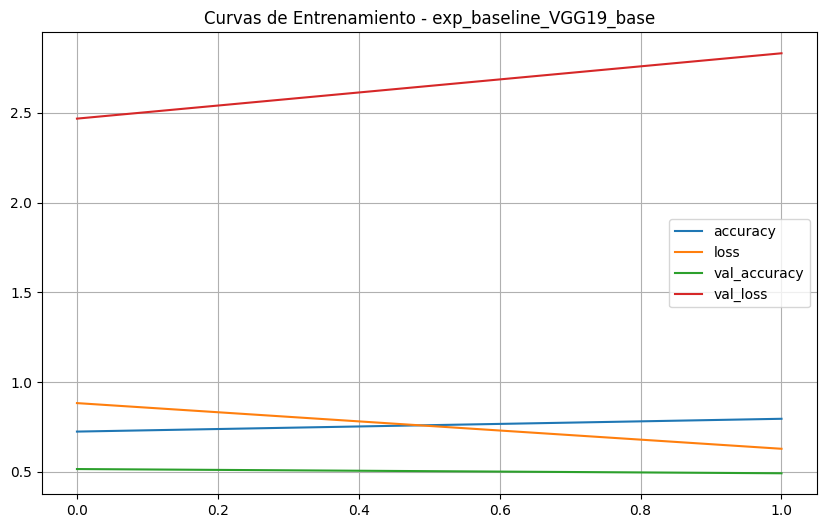


Experimento exp_baseline_VGG19_base finalizado. Resultados en: ../outputs/exp_baseline_VGG19_base


In [10]:
# --- Celda 4: Ciclo de Experimentación (con indentación corregida) ---

# Diccionario para seleccionar el generador correcto fácilmente
train_generators = {
    'conservative': train_generator_conservative,
    'base': train_generator_base # Usando la aumentación 'base'
}

# Definimos los experimentos
experiments = [
    {'model_name': 'InceptionV3',    'augmentation': 'conservative'},
    {'model_name': 'InceptionV3',    'augmentation': 'base'},
    {'model_name': 'VGG19',          'augmentation': 'conservative'},
    {'model_name': 'VGG19',          'augmentation': 'base'}
]

# Bucle principal de experimentos
for exp in experiments:
    # Todo lo que está aquí dentro debe tener UN nivel de indentación
    exp_name = f"exp_baseline_{exp['model_name']}_{exp['augmentation']}"
    print(f"\n{'='*25}\nIniciando Experimento: {exp_name}\n{'='*25}")

    # 1. Crear directorio de salida
    exp_output_dir = os.path.join(OUTPUTS_PATH, exp_name)
    os.makedirs(exp_output_dir, exist_ok=True)

    # 2. Construir el modelo
    model = build_model(model_name=exp['model_name'], num_classes=NUM_CLASSES)
    
    # 3. Definir Callbacks
    callbacks = [
        ModelCheckpoint(os.path.join(exp_output_dir, 'best_model.keras'), monitor='val_accuracy', save_best_only=True, verbose=1),
        EarlyStopping(monitor='val_accuracy', patience=5, verbose=1, restore_best_weights=True),
        CSVLogger(os.path.join(exp_output_dir, 'training_log.csv'))
    ]
    
    # 4. Seleccionar el generador y entrenar
    train_gen = train_generators[exp['augmentation']]
    
    history = model.fit(
        train_gen,
        epochs=EPOCHS,
        validation_data=val_generator,
        callbacks=callbacks
    )

    # 5. Guardar resultados (ESTE BLOQUE DEBE ESTAR ALINEADO COMO SE MUESTRA)
    with open(os.path.join(exp_output_dir, 'history.pkl'), 'wb') as f:
        pickle.dump(history.history, f)
    
    pd.DataFrame(history.history).plot(figsize=(10, 6), grid=True, title=f"Curvas de Entrenamiento - {exp_name}")
    plt.savefig(os.path.join(exp_output_dir, 'training_curves.png'))
    plt.show()

    print(f"\nExperimento {exp_name} finalizado. Resultados en: {exp_output_dir}")
    

In [29]:
# 5. Guardar resultados
    with open(os.path.join(exp_output_dir, 'history.pkl'), 'wb') as f:
        pickle.dump(history.history, f)
    
    pd.DataFrame(history.history).plot(figsize=(10, 6), grid=True, title=f"Curvas de Entrenamiento - {exp_name}")
    plt.savefig(os.path.join(exp_output_dir, 'training_curves.png'))
    plt.show()

    print(f"\nExperimento {exp_name} finalizado. Resultados en: {exp_output_dir}")

IndentationError: unexpected indent (3770113537.py, line 2)

In [13]:
import sys
import os
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import albumentations as A
import pickle
import cv2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger

# Configuración del Path para encontrar el módulo 'src'
project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
if project_root not in sys.path:
    sys.path.append(project_root)
    print(f"Añadido '{project_root}' a sys.path")

from src.architectures import build_model

# --- Rutas y Constantes ---
PROCESSED_DATA_PATH = '../data/processed/'
IMAGE_ROOT_DIR = '../data/raw/color'
OUTPUTS_PATH = '../outputs/'
TARGET_SIZE = (224, 224)
BATCH_SIZE = 32
NUM_CLASSES = 38
EPOCHS = 2 
MODEL_NAME = 'InceptionV3'

print("Cargando dataframes originales (sin balancear)...")
df_splitted = pd.read_csv(os.path.join(PROCESSED_DATA_PATH, 'dataframe_splitted.csv'))
train_df = df_splitted[df_splitted['split'] == 'train']
val_df = df_splitted[df_splitted['split'] == 'valid']
print(f"Usando train_df con {len(train_df)} muestras.")



Cargando dataframes originales (sin balancear)...
Usando train_df con 38013 muestras.


In [14]:
# --- DEFINICIÓN DE AUMENTACIONES Y GENERADORES ---

# Estrategia A: "Geométrica" (replicando la de Keras)
transform_geometric_only = A.Compose([
    A.ShiftScaleRotate(shift_limit=0.25, scale_limit=0.2, rotate_limit=25, border_mode=cv2.BORDER_REPLICATE, p=0.75),
    A.Affine(shear={'x': (-12, 12), 'y': (-12, 12)}, p=0.5),
    A.HorizontalFlip(p=0.5),
    A.Resize(224, 224, always_apply=True)
])

# Estrategia B: "Geométrica + Color"
transform_geometric_and_color = A.Compose([
    A.Rotate(limit=180, p=0.5),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.RandomScale(scale_limit=0.1, p=0.3),
    A.RandomCrop(width=200, height=200, p=0.3),
    A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.3),
    A.HueSaturationValue(hue_shift_limit=20, sat_shift_limit=30, val_shift_limit=20, p=0.3),
    A.GaussianBlur(blur_limit=(3, 5), p=0.2),
    A.Resize(224, 224, always_apply=True),
])

# Función wrapper para Albumentations
def apply_albumentations(image, transform):
    image = (image * 255).astype(np.uint8)
    return transform(image=image)['image'].astype(np.float32) / 255.0

# Generadores
datagen_geometric = ImageDataGenerator(preprocessing_function=lambda x: apply_albumentations(x, transform_geometric_only))
datagen_color = ImageDataGenerator(preprocessing_function=lambda x: apply_albumentations(x, transform_geometric_and_color))
datagen_val = ImageDataGenerator(rescale=1./255)

# Opciones comunes para los generadores
flow_kwargs = {
    'directory': IMAGE_ROOT_DIR,
    'x_col': 'relative_path',
    'y_col': 'class',
    'target_size': TARGET_SIZE,
    'batch_size': BATCH_SIZE,
    'class_mode': 'categorical'
}

train_generator_geometric = datagen_geometric.flow_from_dataframe(dataframe=train_df, shuffle=True, **flow_kwargs)
train_generator_color = datagen_color.flow_from_dataframe(dataframe=train_df, shuffle=True, **flow_kwargs)
val_generator = datagen_val.flow_from_dataframe(dataframe=val_df, shuffle=False, **flow_kwargs)
print("Generadores para ambas estrategias de aumentación listos.")


Found 38013 validated image filenames belonging to 38 classes.
Found 38013 validated image filenames belonging to 38 classes.
Found 5431 validated image filenames belonging to 38 classes.
Generadores para ambas estrategias de aumentación listos.


In [15]:
# --- 4. CICLO DE EXPERIMENTACIÓN ---
experiments = [
    {'name': 'A_Geometric_Only', 'generator': train_generator_geometric},
    {'name': 'B_Geometric_Plus_Color', 'generator': train_generator_color}
]
histories = {}

for exp in experiments:
    exp_name = f"exp_aug_compare_{exp['name']}"
    print(f"\n{'='*25}\nIniciando Experimento: {exp_name}\n{'='*25}")
    exp_output_dir = os.path.join(OUTPUTS_PATH, exp_name)
    os.makedirs(exp_output_dir, exist_ok=True)

    # Construimos el modelo en modo Feature Extraction
    model = build_model(model_name=MODEL_NAME, num_classes=NUM_CLASSES, fine_tune=False)
    
    # El callback guardará el modelo con la menor 'val_loss'
    callbacks = [
        ModelCheckpoint(os.path.join(exp_output_dir, 'best_model.keras'), monitor='val_loss', save_best_only=True, mode='min', verbose=1),
        CSVLogger(os.path.join(exp_output_dir, 'training_log.csv'))
    ]
    
    history = model.fit(
        exp['generator'],
        epochs=EPOCHS,
        validation_data=val_generator,
        callbacks=callbacks
    )
    histories[exp['name']] = pd.DataFrame(history.history)

print("\nTodos los experimentos han finalizado.")



Iniciando Experimento: exp_aug_compare_A_Geometric_Only


TypeError: build_model() got an unexpected keyword argument 'fine_tune'

In [ ]:

# --- 5. COMPARACIÓN VISUAL FINAL (Enfocada en LOSS) ---
plt.figure(figsize=(18, 8))
plt.suptitle(f'Comparación de Aumentación para {MODEL_NAME} (Datos no Balanceados)', fontsize=16)

# Gráfico de Pérdida de Validación (Métrica principal)
plt.subplot(1, 2, 1)
for name, history_df in histories.items():
    plt.plot(history_df['val_loss'], 'o-', label=name)
plt.title('Pérdida en Validación (val_loss)')
plt.xlabel('Época'); plt.ylabel('Pérdida'); plt.grid(True); plt.legend()

# Gráfico de Precisión de Validación (para contexto)
plt.subplot(1, 2, 2)
for name, history_df in histories.items():
    plt.plot(history_df['val_accuracy'], 'o-', label=name)
plt.title('Precisión en Validación (val_accuracy)')
plt.xlabel('Época'); plt.ylabel('Precisión'); plt.grid(True); plt.legend()

comparison_plot_path = os.path.join(OUTPUTS_PATH, 'augmentation_comparison_loss_focused.png')
plt.savefig(comparison_plot_path)
plt.show()